https://www.kaggle.com/rtatman/deceptive-opinion-spam-corpus

This is a Kaggle dataset in which the task is to identify which hotel reviews are fraudulent.  My initial intuition on this was that people who were faking reviews would use more generic (and more, generally) adjectives and adverbs.  I though people would spend a lot of time saying how "very lovely the hotel is and how nicely the staff received" them.   

But it turned out that peole who write real reviews do that too.  The use of specific nouns seems to have mattered more.

The code below is fairly self explanatory, if a bit long.  The basic steps are:

<li> 1) use a CountVectorizer to determine the sentiment (positive or negative reveiw) and the likelyhood of truthfulness
<li> 2) add word count information and re-evaluate
<li> 3) use the initial set of probabilites regarding each question (sentiment and truthfulness) as input to improve the results in turn
<li> 4) perform TF-IDF and iterate as above
<li> 5) select the best probability columns from these efforts
<li> 6) use word2vec vectors (via Spacy) to examine the impact that parts of speech have on the outcomes and iterate again with that new data
<li> 7) add ratios among parts of speech and iterate again

That's a very simplified outline of what has been a fun project.

The results are at the bottom.  I think it can be improved further by considering the probability that any particular review is genuinely specific to a given hotel, so that's a step I may add in the future.

In [249]:
%matplotlib inline
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt  


from IPython.display import display
pd.options.display.max_colwidth = 150
import re

## Spacy
import spacy
nlp = spacy.load('en')
from spacy.lang.en.stop_words import STOP_WORDS

## feature generation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Gensim
import gensim
from gensim.models.doc2vec import TaggedDocument

## NLTK
import nltk
from nltk import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

## learning
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## dimensional reduction though TSNE and PCA
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE

## clustering
from sklearn.cluster import DBSCAN

## randomizing the data
import random

print 'ready'

ready


In [250]:
data = pd.read_csv('tabbed_data.txt', sep='\t', quoting=3, encoding="utf-8")
data.head(1)

,deceptive,hotel,polarity,source,review
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose ...


In [251]:
## A simple but important step.  A number of the steps below
## depend on returning probabilities from learning algorithms 
## for all the data, not just randomized test data.
data = data.sample(frac=1)

## make any dataframe use this new shuffled index
def set_to_data_index(df):
    df['orig_index'] = data.index
    df.set_index('orig_index', drop=True, inplace=True)
    return df

In [252]:
data['wc'] = data.review.str.count('\w+') # word count

#data.polarity.value_counts()
data['sentiment']    = 0
data['truthfulness'] = 0

positive_rows  = data[data.polarity  == 'positive' ].index
negative_rows  = data[data.polarity  == 'negative' ].index
truthful_rows  = data[data.deceptive == 'truthful' ].index
deceptive_rows = data[data.deceptive == 'deceptive'].index

data.set_value(positive_rows,  'sentiment',  1)
data.set_value(negative_rows,  'sentiment', -1)
data.set_value(truthful_rows,  'truthfulness',  1)
data.set_value(deceptive_rows, 'truthfulness', -1)

data = data.drop(['deceptive', 'polarity'], axis=1)
display(data.head(5))
display(data.tail(5))

,hotel,source,review,wc,sentiment,truthfulness
177,affinia,TripAdvisor,The recently remodeled Affina was amazing - from the 6 choice pillow menu to the stocked 'pantry and refrigerator' to the brand name bathroom amme...,88,1,1
484,homewood,MTurk,I really enjoyed staying at this hotel. The separated living room and bedroom made it feel like I was renting a nice furnished apartment instead o...,100,1,-1
193,ambassador,TripAdvisor,The staff recognizes you by name with excellent eye contact. The 'welcome back' sets the tone for your stay. Flowers in the lobby and reception ar...,61,1,1
851,fairmont,Web,"The bathroom toilet leaked water all over the bathroom every time it was flushed, so we called maintenance to have it fixed. We returned to our ro...",82,-1,1
1380,ambassador,MTurk,"I recently stayed at the Ambassador East Hotel for two night, and my visit was nothing short of disappointing. Expecting to have a wonderfully rom...",148,-1,-1


,hotel,source,review,wc,sentiment,truthfulness
447,hyatt,MTurk,"The Hyatt Regency Chicago hotel was a delight to stay at. I've never been to Chicago before, but the location was fantastic. They had all sorts of...",92,1,-1
1080,hilton,Web,"Had a week long stay at the Hilton on south Michigan while attending a meeting. The hotel has some elegance in the lobby, meeting rooms and lounge...",128,-1,1
1121,intercontinental,Web,Used this hotel the first time I was in Chicago. For the prices and for being classified an intercontinental...I wouldn't consider it that good. T...,124,-1,1
1292,swissotel,MTurk,"I was very disappointed with this hotel. I have stayed in other Swissotels and enjoyed them very much, but the service can only be described as al...",152,-1,-1
638,hardrock,MTurk,"the experince at the hard rock hotel in chicago was fantastic,i will rate them a 6 out of 5. they have wonderful service and great staff and the v...",33,1,-1


In [253]:
def make_xy(d, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(d.review)
    y_positive = (d.sentiment == 1).values.astype(np.int)
    y_truthful = (d.truthfulness == 1).values.astype(np.int)
    return X, y_positive, y_truthful, vectorizer

X, y_positive, y_truthful, vect = make_xy(data)

In [254]:
## eyeballing the sparse vector of word counts
xdata = pd.DataFrame(X.A, columns=vect.get_feature_names()) # X.A = X.toarray()
print len(xdata), "documents"
print len(xdata.columns), "words"
xdata.head()
#xdata.loc[3]['hell']

1600 documents
9571 words


,00,000,00a,00am,00pm,03,04,05,06,07,...,yum,yummo,yummy,yunan,yup,zagat,zest,zipped,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [255]:
## learn if the review is positive or nagative (y_positive as y column)
X_val, X_train, y_val, y_train = train_test_split(X, y_positive)
clf_sentimentdetector = MultinomialNB(alpha=1.0)
clf_sentimentdetector.fit(X_train, y_train)
#y_pred = clf_polarity.predict(X_val)

## get predictions and probabilities on all the data
y_res_polarity   = clf_sentimentdetector.predict(X)
y_probs_polarity = clf_sentimentdetector.predict_proba(X)
y_prob_pd        = pd.DataFrame(y_probs_polarity)
y_prob_pd.rename(columns={0:'negative', 1:'positive'}, inplace=True)
y_prob_pd = set_to_data_index(y_prob_pd)
display(y_prob_pd.head(1))
#y_prob_pd['polarity_prediction'] = y_res_polarity

print 'sentiment detection score on test data:', clf_sentimentdetector.score(X_val, y_val)



## learn if the review is truthful or deceptive (y_truthful as y column)
X_val, X_train, y_val, y_train = train_test_split(X, y_truthful) 
clf_truthdetector = MultinomialNB(alpha=1.0)
clf_truthdetector.fit(X_train, y_train)
#y_pred = clf_deception.predict(X_val)

## get predictions and probabilities on all the data
y_res_deceptive     = clf_truthdetector.predict(X)
y_probs_deceptive   = clf_truthdetector.predict_proba(X)
y_prob_deceptive_pd = pd.DataFrame(y_probs_deceptive)
y_prob_deceptive_pd.rename(columns={0:'deceptive', 1:'truthful'}, inplace=True)
y_prob_deceptive_pd = set_to_data_index(y_prob_deceptive_pd)
display(y_prob_deceptive_pd.head(1))
#y_prob_pd['truthfulness_prediction'] = y_res_deceptive

y_prob_pd = y_prob_pd.merge(y_prob_deceptive_pd, left_index=True, right_index=True)

print '    truth detection score on test data:', clf_truthdetector.score(X_val, y_val)

,negative,positive
orig_index,,
177,0.002373,0.997627


sentiment detection score on test data: 0.8925


,deceptive,truthful
orig_index,,
177,0.999936,0.000064


    truth detection score on test data: 0.8416666666666667


In [256]:
## y_prob_pd contains the independent probabilities of both types of classification
## (truthulness & sentiment) to the extent that they can be inferred from simple 
## word counts.

y_prob_pd['truthfulness'] = data['truthfulness']
y_prob_pd['sentiment']    = data['sentiment']
y_prob_pd['wc']           = data['wc']

display(y_prob_pd.head(5))
display(y_prob_pd.tail(5))

,negative,positive,deceptive,truthful,truthfulness,sentiment,wc
orig_index,,,,,,,
177,0.002373,9.976271e-01,0.999936,0.000064,1,1,88
484,0.000004,9.999961e-01,0.999994,0.000006,-1,1,100
193,0.000006,9.999940e-01,0.224244,0.775756,1,1,61
851,1.000000,9.176637e-11,0.357649,0.642351,1,-1,82
1380,1.000000,6.317782e-11,0.999996,0.000004,-1,-1,148


,negative,positive,deceptive,truthful,truthfulness,sentiment,wc
orig_index,,,,,,,
447,0.991088,8.911734e-03,1.000000e+00,3.778929e-08,-1,1,92
1080,0.608018,3.919819e-01,5.174522e-01,4.825478e-01,1,-1,128
1121,1.000000,1.207235e-11,1.651768e-07,9.999998e-01,1,-1,124
1292,1.000000,4.050450e-18,1.000000e+00,1.850532e-11,-1,-1,152
638,0.000592,9.994081e-01,2.623558e-01,7.376442e-01,-1,1,33


In [270]:
## looking at the probabilities (of truthfulness) associated with individual words
word_list = vect.get_feature_names()
wpd       = pd.DataFrame(word_list)

xx                = np.eye(X.shape[1])
word_probs        = clf_truthdetector.predict_proba(xx)[:, 1]
wpd['word_probs'] = word_probs

display(wpd.sort_values('word_probs', ascending=False).head(20))
display(wpd.sort_values('word_probs', ascending=False).tail(20))

,0,word_probs
5174,main,0.919296
3601,four,0.919296
7452,separate,0.912601
6470,priceline,0.912601
7124,river,0.908818
2765,doormen,0.904694
6979,request,0.904694
1641,charges,0.904694
1444,cab,0.900178
4429,including,0.895214


,0,word_probs
334,accommodations,0.159558
7768,smelled,0.159558
3564,forever,0.159558
6885,relaxing,0.151092
6246,pillow,0.147187
466,affinia,0.143480
8454,television,0.136597
5625,needless,0.136597
3313,fairly,0.136597
913,award,0.136597


Observe interesting word count profiles. 

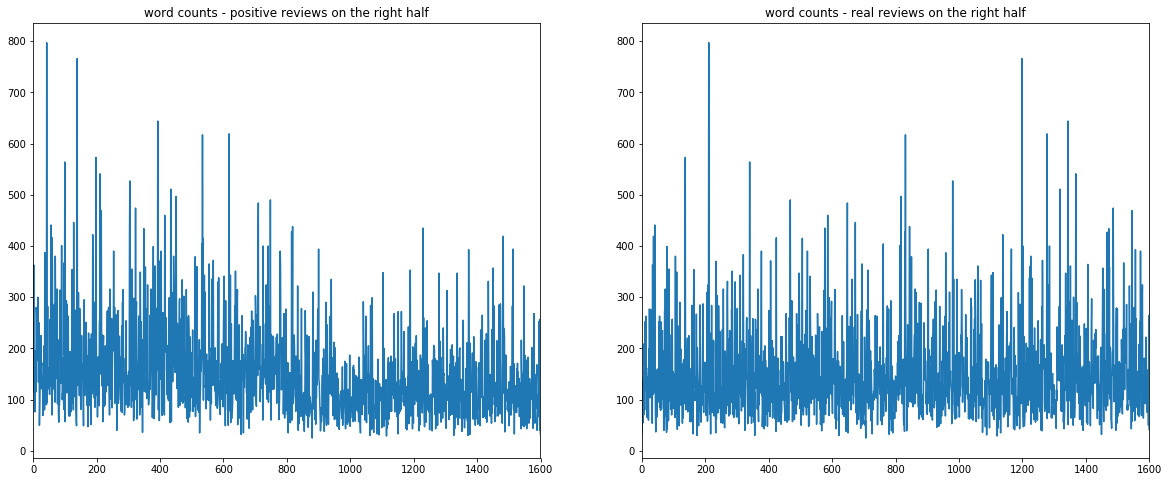

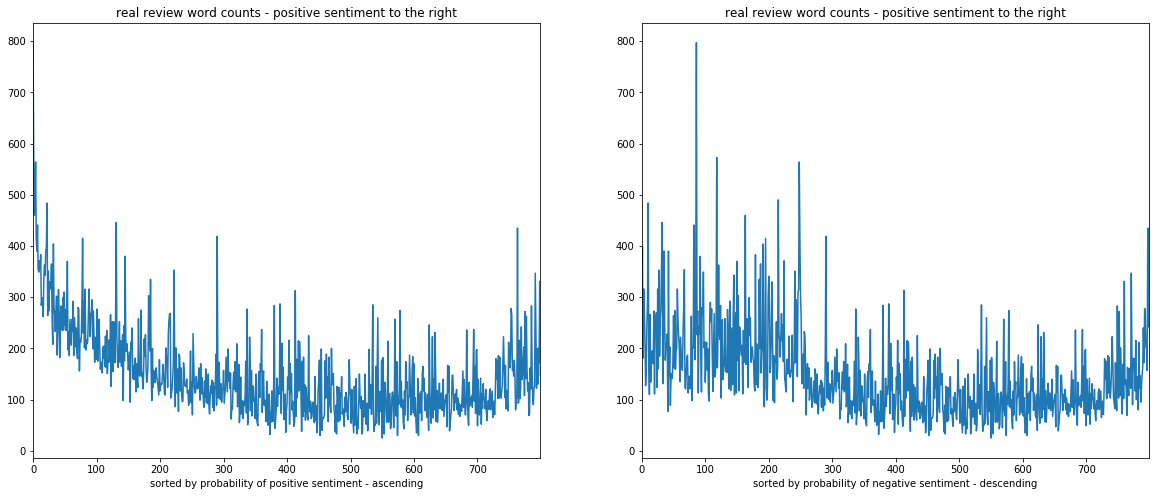

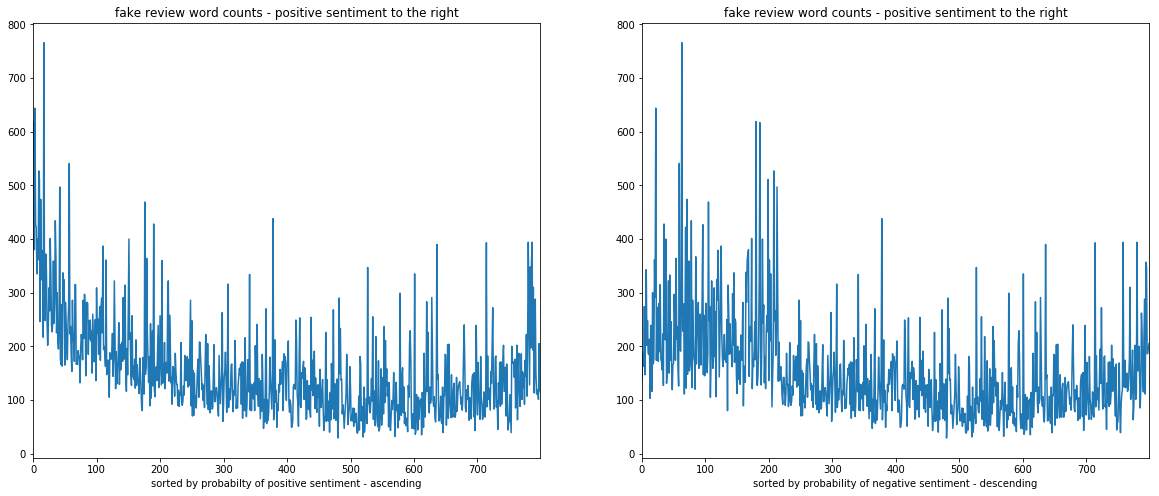

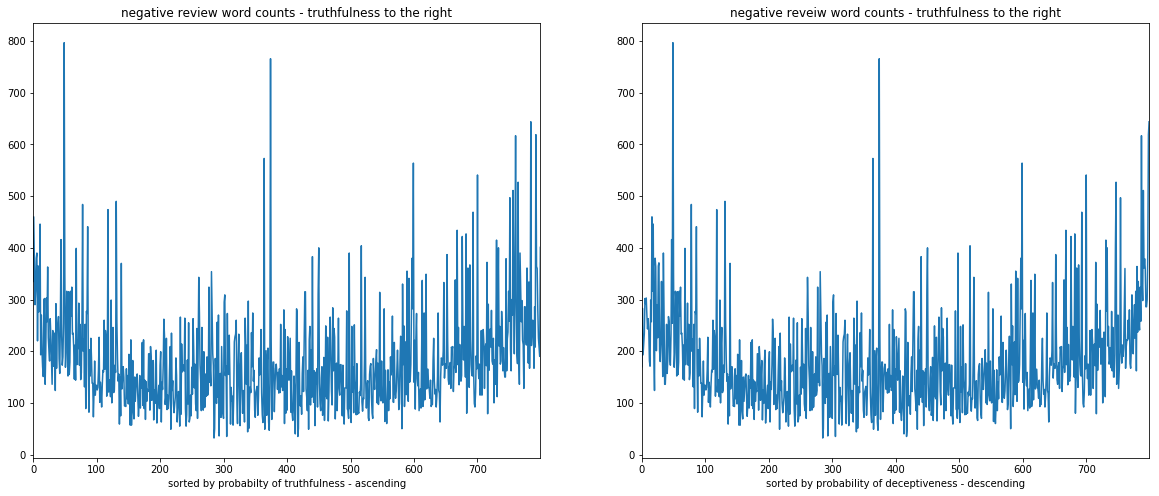

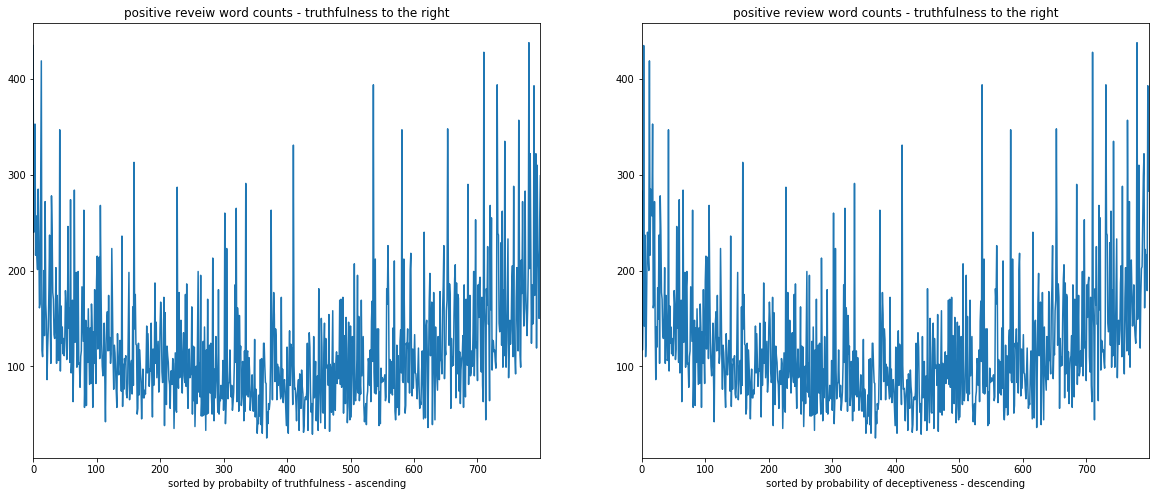

In [258]:
fig, axs = plt.subplots(1,2, figsize=(20, 8))
y_prob_pd.sort_values('sentiment', ascending=True).reset_index().wc.plot(ax=axs[0]); 
y_prob_pd.sort_values('truthfulness', ascending=True).reset_index().wc.plot(ax=axs[1]); 
axs[0].set_title('word counts - positive reviews on the right half')
axs[1].set_title('word counts - real reviews on the right half')
plt.show();

fig, axs = plt.subplots(1,2, figsize=(20, 8))
y_prob_pd[y_prob_pd.truthfulness == -1].sort_values('positive', ascending=True)\
                                              .reset_index().wc.plot(ax=axs[0]); 
y_prob_pd[y_prob_pd.truthfulness == -1].sort_values('negative', ascending=False)\
                                               .reset_index().wc.plot(ax=axs[1]); 
axs[0].set_title('real review word counts - positive sentiment to the right')
axs[1].set_title('real review word counts - positive sentiment to the right')
axs[0].set_xlabel('sorted by probability of positive sentiment - ascending')
axs[1].set_xlabel('sorted by probability of negative sentiment - descending')
plt.show();

fig, axs = plt.subplots(1,2, figsize=(20, 8))
y_prob_pd[y_prob_pd.truthfulness == 1].sort_values('positive', ascending=True)\
                                             .reset_index().wc.plot(ax=axs[0]); 
y_prob_pd[y_prob_pd.truthfulness == 1].sort_values('negative', ascending=False)\
                                              .reset_index().wc.plot(ax=axs[1]); 
axs[0].set_title('fake review word counts - positive sentiment to the right')
axs[1].set_title('fake review word counts - positive sentiment to the right')
axs[0].set_xlabel('sorted by probabilty of positive sentiment - ascending')
axs[1].set_xlabel('sorted by probability of negative sentiment - descending')
plt.show();


fig, axs = plt.subplots(1,2, figsize=(20, 8))
y_prob_pd[y_prob_pd.sentiment == -1].sort_values('truthful',  ascending=True)\
                                            .reset_index().wc.plot(ax=axs[0]); 
y_prob_pd[y_prob_pd.sentiment == -1].sort_values('deceptive', ascending=False)\
                                             .reset_index().wc.plot(ax=axs[1]); 
axs[0].set_title('negative review word counts - truthfulness to the right')
axs[1].set_title('negative reveiw word counts - truthfulness to the right')
axs[0].set_xlabel('sorted by probabilty of truthfulness - ascending')
axs[1].set_xlabel('sorted by probability of deceptiveness - descending')
plt.show();

fig, axs = plt.subplots(1,2, figsize=(20, 8))
y_prob_pd[y_prob_pd.sentiment == 1].sort_values('truthful',  ascending=True)\
                                           .reset_index().wc.plot(ax=axs[0]); 
y_prob_pd[y_prob_pd.sentiment == 1].sort_values('deceptive', ascending=False)\
                                            .reset_index().wc.plot(ax=axs[1]); 
axs[0].set_title('positive reveiw word counts - truthfulness to the right')
axs[1].set_title('positive review word counts - truthfulness to the right')
axs[0].set_xlabel('sorted by probabilty of truthfulness - ascending')
axs[1].set_xlabel('sorted by probability of deceptiveness - descending')
plt.show();

Now use the word counts and previously generated probabilies to try to improve the results

In [259]:
def featured_make_xy(d, xlist, y): 
    x_features = d[xlist]
    print "Using these features:", list(x_features)

    y_feature = d[y]
    return x_features, y_feature


def learn_from(d, xlist, y):
    x_features, y_feature = featured_make_xy(d, xlist, y)
    xtrain, xtest, ytrain, ytest = train_test_split(x_features, y_feature, test_size=0.50) 
    print xtrain.shape
    
    brain = MultinomialNB(alpha=1.0)
    brain.fit(xtrain, ytrain)
    
    predictions_on_test = brain.predict(xtest)
    predictions_on_all  = brain.predict(x_features)
    y_probs             = brain.predict_proba(x_features)

    print 'accuracy on test data = ', accuracy_score(ytest, predictions_on_test)
    print ' accuracy on all data = ', accuracy_score(y_feature, predictions_on_all)
    return y_probs


## let's use the word count and previous probabilities to improve the 
## sentiment prediction. 
xlist = ['negative', 'positive', 'deceptive', 'truthful', 'wc']
y_probs_polarity = learn_from(y_prob_pd, xlist, 'sentiment')

y_prob_polarity_update = pd.DataFrame(y_probs_polarity)
y_prob_polarity_update.rename(columns={0:'negative2', 1:'positive2'}, inplace=True)
y_prob_polarity_update = set_to_data_index(y_prob_polarity_update)

y_prob_pd['negative'] = y_prob_polarity_update['negative2']
y_prob_pd['positive'] = y_prob_polarity_update['positive2']
display(y_prob_pd.head())

## now use the word count and updated polarity probabilities to improve the 
## truthfulness prediction.  
xlist = ['negative', 'positive', 'deceptive', 'truthful', 'wc']
y_probs_truthfulness = learn_from(y_prob_pd, xlist, 'truthfulness')

y_prob_truthfulness_update = pd.DataFrame(y_probs_truthfulness)
y_prob_truthfulness_update.rename(columns={0:'deceptive2', 1:'truthful2'}, inplace=True)
y_prob_truthfulness_update = set_to_data_index(y_prob_truthfulness_update)

y_prob_pd['deceptive'] = y_prob_truthfulness_update['deceptive2']
y_prob_pd['truthful']  = y_prob_truthfulness_update['truthful2']
display(y_prob_pd.head())

Using these features: ['negative', 'positive', 'deceptive', 'truthful', 'wc']
(800, 5)
accuracy on test data =  0.93375
 accuracy on all data =  0.923125


,negative,positive,deceptive,truthful,truthfulness,sentiment,wc
orig_index,,,,,,,
177,0.026831,0.973169,0.999936,0.000064,1,1,88
484,0.028478,0.971522,0.999994,0.000006,-1,1,100
193,0.023837,0.976163,0.224244,0.775756,1,1,61
851,0.813871,0.186129,0.357649,0.642351,1,-1,82
1380,0.862047,0.137953,0.999996,0.000004,-1,-1,148


Using these features: ['negative', 'positive', 'deceptive', 'truthful', 'wc']
(800, 5)
accuracy on test data =  0.885
 accuracy on all data =  0.880625


,negative,positive,deceptive,truthful,truthfulness,sentiment,wc
orig_index,,,,,,,
177,0.026831,0.973169,0.877905,0.122095,1,1,88
484,0.028478,0.971522,0.877683,0.122317,-1,1,100
193,0.023837,0.976163,0.278181,0.721819,1,1,61
851,0.813871,0.186129,0.374688,0.625312,1,-1,82
1380,0.862047,0.137953,0.869862,0.130138,-1,-1,148


TFIDF might reveal something.  The intuition would be that fake reviews should, in general, use more generic language because the writers aren't remembering a real event.  Presumably, that generic langauge will appear more often and its value will be downgraded.

In [260]:
def tknize(sen):
    # working with raw text here.  no reference to word2vec needed.
    tkns = [word.lower() for word in tokenizer.tokenize(sen)]
    return tkns


## remove the tf_idf columns from y_prob_pd if they were there before
y_prob_columns = list(y_prob_pd)
if('tf_deceptive' in y_prob_columns): y_prob_pd.drop('tf_deceptive', axis=1, inplace=True)
if('tf_truthful' in y_prob_columns):  y_prob_pd.drop('tf_truthful', axis=1, inplace=True)
if('tf_positive' in y_prob_columns):  y_prob_pd.drop('tf_positive', axis=1, inplace=True)
if('tf_negative' in y_prob_columns):  y_prob_pd.drop('tf_negative', axis=1, inplace=True)
    
    
## run TF_IDF and add the probabilities returned to y_prob_pd  
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), \
                    use_idf=True, tokenizer=tknize, stop_words=None)
tf_X = tf.fit_transform(data.review) 


## polarity
y_column = y_prob_pd['sentiment']
xtrain, xtest, ytrain, ytest = train_test_split(tf_X, y_column, test_size=0.5)
tf_clf_polarity   = MultinomialNB(alpha=1).fit(xtrain, ytrain)
tf_probs_polarity = tf_clf_polarity.predict_proba(tf_X)

tf_pd_polarity = pd.DataFrame(tf_probs_polarity)
tf_pd_polarity.rename(columns={0:'tf_negative', 1:'tf_positive'}, inplace=True)
tf_pd_polarity = set_to_data_index(tf_pd_polarity)

y_prob_pd = y_prob_pd.merge(tf_pd_polarity, left_index=True, right_index=True)

predictions_test_data = tf_clf_polarity.predict(xtest)
print '   sentiment accuracy on test data = ', accuracy_score(ytest, predictions_test_data)


## truthfulness
y_column = y_prob_pd['truthfulness']
xtrain, xtest, ytrain, ytest = train_test_split(tf_X, y_column, test_size=0.5)
tf_clf_truthfulness   = MultinomialNB(alpha=1).fit(xtrain, ytrain)
tf_probs_truthfulness = tf_clf_truthfulness.predict_proba(tf_X)
    
tf_pd_truthfulness = pd.DataFrame(tf_probs_truthfulness)
tf_pd_truthfulness.rename(columns={0:'tf_deceptive', 1:'tf_truthful'}, inplace=True)
tf_pd_truthfulness = set_to_data_index(tf_pd_truthfulness)

y_prob_pd = y_prob_pd.merge(tf_pd_truthfulness, left_index=True, right_index=True)


predictions_test_data = tf_clf_truthfulness.predict(xtest)
print 'truthfulness accuracy on test data = ', accuracy_score(ytest, predictions_test_data)

#predictions_all_data = tf_clf.predict(tf_X)
#print ' accuracy on all data = ', accuracy_score(y_column, predictions_all_data)
display(y_prob_pd.head())

   sentiment accuracy on test data =  0.93125
truthfulness accuracy on test data =  0.855


,negative,positive,deceptive,truthful,truthfulness,sentiment,wc,tf_negative,tf_positive,tf_deceptive,tf_truthful
orig_index,,,,,,,,,,,
177,0.026831,0.973169,0.877905,0.122095,1,1,88,0.344788,0.655212,0.360937,0.639063
484,0.028478,0.971522,0.877683,0.122317,-1,1,100,0.457965,0.542035,0.590642,0.409358
193,0.023837,0.976163,0.278181,0.721819,1,1,61,0.428956,0.571044,0.481530,0.518470
851,0.813871,0.186129,0.374688,0.625312,1,-1,82,0.683522,0.316478,0.468174,0.531826
1380,0.862047,0.137953,0.869862,0.130138,-1,-1,148,0.773169,0.226831,0.763020,0.236980


One iteration of TFIDF is ok, but a second pass might help.

In [262]:
## Again, recycle the previous results and add in word count data to try
## to improve the results.  In this case, the sentiment results don't improve
## over what we had previously so y_prob_pd is not updated with them.


print "sentiment:"
xlist = ['wc','tf_negative', 'tf_positive']
y_probs_polarity = learn_from(y_prob_pd, xlist, 'sentiment')



print "truthfulness:"
xlist = ['wc','tf_deceptive', 'tf_truthful']
y_probs_truthfulness = learn_from(y_prob_pd, xlist, 'truthfulness')

y_prob_truthfulness_update = pd.DataFrame(y_probs_truthfulness)
y_prob_truthfulness_update.rename(columns={0:'tf_deceptive2', 1:'tf_truthful2'}, inplace=True)
y_prob_truthfulness_update = set_to_data_index(y_prob_truthfulness_update)

y_prob_pd['tf_deceptive'] = y_prob_truthfulness_update['tf_deceptive2']
y_prob_pd['tf_truthful']  = y_prob_truthfulness_update['tf_truthful2']

display(y_prob_pd.head())

sentiment:
Using these features: ['wc', 'tf_negative', 'tf_positive']
(800, 3)
accuracy on test data =  0.93
 accuracy on all data =  0.928125
truthfulness:
Using these features: ['wc', 'tf_deceptive', 'tf_truthful']
(800, 3)
accuracy on test data =  0.92
 accuracy on all data =  0.928125


,negative,positive,deceptive,truthful,truthfulness,sentiment,wc,tf_negative,tf_positive,tf_deceptive,tf_truthful
orig_index,,,,,,,,,,,
177,0.026831,0.973169,0.877905,0.122095,1,1,88,0.344788,0.655212,0.446937,0.553063
484,0.028478,0.971522,0.877683,0.122317,-1,1,100,0.457965,0.542035,0.523021,0.476979
193,0.023837,0.976163,0.278181,0.721819,1,1,61,0.428956,0.571044,0.490513,0.509487
851,0.813871,0.186129,0.374688,0.625312,1,-1,82,0.683522,0.316478,0.483658,0.516342
1380,0.862047,0.137953,0.869862,0.130138,-1,-1,148,0.773169,0.226831,0.575364,0.424636


The best results so far are the CountVectorizer results for Sentiment and the TFIDF results for Truthfulness.  Let's throw that data into a random forest and see if we can lock it down.

In [263]:
def make_forest_xy(d, xlist, y_column): 
    X = d[xlist]
    print "Using these features:", list(X)

    y = d[y_column]
    return X, y


def forest_learn_from(y_prob_pd, xlist, y_column):
    x, y = make_forest_xy(y_prob_pd, xlist, y_column)
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.80) 
    print xtrain.shape

    brain = RandomForestClassifier(n_estimators=50,          # number of trees
                                       criterion='entropy',  # default: 'gini'
                                       random_state=1)
    brain.fit(xtrain, ytrain)
    predictions_on_test = brain.predict(xtest)
    predictions_on_all  = brain.predict(x)

    print '            accuracy:', accuracy_score(ytest, predictions_on_test)
    print "accuracy on all data:", accuracy_score(y, predictions_on_all)
    return predictions_on_all

xlist = ['negative', 'positive', 'wc', 'tf_deceptive', 'tf_truthful']
#xlist = ['negative', 'positive', 'wc', 'deceptive', 'truthful', \
#         'tf_negative', 'tf_positive', 'tf_deceptive', 'tf_truthful']
y_column = 'truthfulness'
all_predictions = forest_learn_from(y_prob_pd, xlist, y_column)

Using these features: ['negative', 'positive', 'wc', 'tf_deceptive', 'tf_truthful']
(320, 5)
            accuracy: 0.9171875
accuracy on all data: 0.9325


These results are not half bad.  Now I want to think less about the prediction result and more about what's happening.

Below are the TFIDF scores themselves.  The table only shows scores for individual words, not including 2-grams and 3-grams, because with such a small dataset it's likely that those 2 and 3 grams are specific to just a few records.  

In [264]:
tfwordlist  = tf.get_feature_names()
fn          = pd.DataFrame(tf.get_feature_names())
fn['score'] = tf.idf_
fn['tf_wc'] = fn[0].str.count('\w+')
fn.rename(columns={0:'tf_ngram'}, inplace=True)
fn['normscore'] = (fn['score'] - fn['score'].min())/(fn['score'].max() - fn['score'].min())

## these are the TFIDF scores
display(fn[fn['tf_wc'] == 1].sort_values('score', ascending=False).head())
display(fn[fn['tf_wc'] == 1].sort_values('score', ascending=False).tail())

,tf_ngram,score,tf_wc,normscore
69914,einstein,7.685237,1,1.0
86490,frquently,7.685237,1,1.0
86590,fulfilled,7.685237,1,1.0
86583,fugitive,7.685237,1,1.0
86580,fucking,7.685237,1,1.0


,tf_ngram,score,tf_wc,normscore
109233,in,1.135586,1,0.019362
220764,to,1.083327,1,0.011538
3670,a,1.061836,1,0.008320
17462,and,1.020190,1,0.002085
203468,the,1.006266,1,0.000000


This is a visualization trick.  The idea is to force word vectors apart according to some desired quality so that, when they're plotted, that quality stands out.  For example, you could use this to emphasize the TFIDF score.  When the rotated vectors are averaged into their respective reviews, it should be possible to see the presense of that quality in the aggregate.

                 word: river
BOW predictive factor: 0.8259506027061063
                 word: very
BOW predictive factor: 0.31068592871376693
                 word: deluxe
BOW predictive factor: 0.014259604068542514


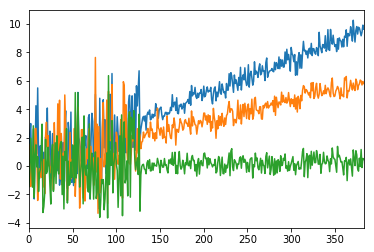

In [278]:
def rotate_vector(v, factor):
    ## rotation factors are between 0 and .5 because I find that easier
    ## to debug.  But those numbers are still much too large, so the factors
    ## are further reduced below
    
    if(factor >= .5): factor = .5 # Should never happen  
    nv = []
    ic = 0
    for i in v:
        ni = i + ic
        nv.append(ni)
        ic = ic + (.05 * factor)
    return nv


def demo_rotation(sample):
    sdoc   = nlp(sample)
    sword  = sdoc[0]
    v      = sword.vector

    word_row = wpd[wpd[0] == sword.orth_].index.tolist()[0]
    factor   = wpd.loc[word_row]['word_probs']
    factor = factor * factor
    v1 = rotate_vector(v, factor)
    pd.Series(v1).plot();

    print '                 word:', sample
    print 'BOW predictive factor:', factor
    
#sample = u'construction'
#demo_rotation(u'kitten')
demo_rotation(u'river')
demo_rotation(u'very')
#demo_rotation(u'read')
demo_rotation(u'deluxe')

In [280]:
iword = u'read'
idoc  = nlp(iword)
iread = idoc[0]
iword_vector = iread.vector
#iword_vector = reviews_model['read']  # a word with a very low predictive value

count = 0
mark  = 100
vectors      = []
adjj_vectors = []
advv_vectors = []
verb_vectors = []
noun_vectors = []
type_ratios  = []
for i in data.index:
    q = data.loc[i].review 
    doc = nlp(q)
    sent_wordvectors = []
    adjj_wordvectors = []
    advv_wordvectors = []
    verb_wordvectors = []
    noun_wordvectors = []
    prcount = 0
    for word in doc:
        lorth = word.orth_.lower()
        ## skip a bunch of uninteresting words
        if(word.orth_.lower() not in word_list): continue
        if(word.dep_ == 'punct'):                continue
        if(word.orth_.lower in STOP_WORDS):      continue
        if(word.orth_ in STOP_WORDS):            continue
            
        ## get the rotated vector fot this word
        ptvec = word.vector

        ## every word is in wpd, so this is safe
        word_row = wpd[wpd[0] == lorth].index.tolist()[0]
        factor   = wpd.loc[word_row]['word_probs']
        factor = factor * factor
        
        pv1 = rotate_vector(ptvec, factor)
            
        ## adjectives & adverbs together
        if((word.tag_ == 'JJ') | (word.tag_ == 'ADV')): 
            adjj_wordvectors.append(pv1)
            
        ## verbs
        if(word.pos_ == 'VERB'): 
            verb_wordvectors.append(pv1)
            
        ## nouns and pronouns
        if((word.pos_ == 'NOUN') | (word.pos_ == 'PRON')): 
            noun_wordvectors.append(pv1)
                       
        ## all the words in the sentence (not including stop_words, punct, ...)       
        sent_wordvectors.append(pv1)
    
    ## whole sentence 
    senvec_pd = pd.DataFrame(sent_wordvectors)
    senlen    = len(senvec_pd)
    v         = senvec_pd.sum(axis=0)/float(senlen)
    vectors.append(v)
    ## _______________________________________________________________________
    
    ## adjectives and adverbs
    adjj_tokens_pd      = pd.DataFrame(adjj_wordvectors)
    adjj_tokenlen       = len(adjj_tokens_pd)
    adjj_tokens_blurred = adjj_tokens_pd.sum(axis=0)/float(adjj_tokenlen)
    
    if(adjj_tokenlen > 0):
        adjj_vectors.append(adjj_tokens_blurred)
    else:
        adjj_vectors.append(iword_vector)
    ## _______________________________________________________________________
        
        
    ## verbs 
    verb_tokens_pd      = pd.DataFrame(verb_wordvectors)
    verb_tokenlen       = len(verb_tokens_pd)
    verb_tokens_blurred = verb_tokens_pd.sum(axis=0)/float(verb_tokenlen)
    
    if(verb_tokenlen > 0):
        verb_vectors.append(verb_tokens_blurred)
    else:
        verb_vectors.append(iword_vector)
    ## _______________________________________________________________________
        
        
    ## nouns and pronouns
    noun_tokens_pd      = pd.DataFrame(noun_wordvectors)
    noun_tokenlen       = len(noun_tokens_pd)
    noun_tokens_blurred = noun_tokens_pd.sum(axis=0)/float(noun_tokenlen)
    
    if(noun_tokenlen > 0):
        noun_vectors.append(noun_tokens_blurred)
    else:
        noun_vectors.append(iword_vector)
            
            
    type_ratios.append((senlen, adjj_tokenlen, verb_tokenlen, noun_tokenlen))

    
    if(count >= mark): print i; count = 0;
    count = count + 1
    
    
print 'vectors inferred from document contents'    

896
1085
30
130
1177
199
979
209
1065
833
31
1367
50
967
583
vectors inferred from document contents


In [286]:
def check_for_baddata(matrix):
    rval = 0
    df = pd.DataFrame(matrix)
    #all_maxes = df.max()
    #print max(all_maxes)
    dflist = list(df)
    for dfl in dflist:
        baddata = df[df[dfl] == np.nan]
        if(len(baddata) > 0): 
            display(baddata)
            rval = 1
        
        baddata = df[df[dfl] == np.inf]
        if(len(baddata) > 0): 
            display(baddata)
            rval = 2
        
        baddata = df[df[dfl] == -np.inf]
        if(len(baddata) > 0): 
            display(baddata)
            rval = 3
        return rval

In [287]:
def reduce_data(vectors_df, xity):
    #vectors_df = pd.DataFrame(theme_vectors)
    psv        = np.asarray(vectors_df)
    print 'baddata score:', check_for_baddata(psv)
    
    if(xity == 0): xity = 30  # the default value

#    ts_psen = TSNE(n_components=2, \
                #   perplexity=xity, \
                #   early_exageration=12,\
                #   learning_rate=200, \
                #   n_iter=1000).fit_transform(psv)
    ts_psen = TSNE(n_components=2, n_iter=3000).fit_transform(psv)
    vectors_df['x'] = ts_psen[:,0]
    vectors_df['y'] = ts_psen[:,1]
    print 'tsne complete'
    
    vectors_df['sentiment']    = data['sentiment']
    vectors_df['truthfulness'] = data['truthfulness']
    
    return vectors_df

def show_reduced(vectors_df):
    fig, ax = plt.subplots(1,1, figsize=(8, 5))
    vectors_df[vectors_df.truthfulness == -1].plot(ax=ax,kind='scatter',x='x',y='y',c='orange',s=5)
    vectors_df[vectors_df.truthfulness ==  1].plot(ax=ax,kind='scatter',x='x',y='y',c='blue',  s=5)
    
    ax.axvline(vectors_df[vectors_df.truthfulness == -1].x.mean(), color='orange')
    ax.axvline(vectors_df[vectors_df.truthfulness ==  1].x.mean(), color='blue')
    ax.axhline(vectors_df[vectors_df.truthfulness == -1].y.mean(), color='orange')
    ax.axhline(vectors_df[vectors_df.truthfulness ==  1].y.mean(), color='blue');
    
def show_clustered(vectors_df):
    fig, ax = plt.subplots(1,1, figsize=(8, 5))
    vectors_df.plot(ax=ax,kind='scatter',x='x',y='y', s=15, c='db_labels', cmap='gist_stern')
    ax.set_facecolor((1.0, 0.47, 0.42))
    
    ax.axvline(vectors_df[vectors_df.truthfulness == -1].x.mean(), color='orange')
    ax.axvline(vectors_df[vectors_df.truthfulness ==  1].x.mean(), color='blue')
    ax.axhline(vectors_df[vectors_df.truthfulness == -1].y.mean(), color='orange')
    ax.axhline(vectors_df[vectors_df.truthfulness ==  1].y.mean(), color='blue');

In [288]:
from sklearn.cluster import MeanShift, estimate_bandwidth

def db_scan_for_df(df):
    X = df[['x', 'y']]
    dbmodel = DBSCAN(eps=1.5, min_samples=1).fit(X)
    ##dbmodel = DBSCAN(eps=5.1, min_samples=12).fit(X)
    #print 'dbmodel ready'

    ##print dbmodel
    ##print dbmodel.core_sample_indices_
    ##print dbmodel.labels_
    df['db_labels']    = dbmodel.labels_
    df['sentiment']    = data['sentiment']
    df['truthfulness'] = data['truthfulness']

    db_pd = pd.DataFrame(dbmodel.labels_)
    db_pd_vc = db_pd[0].value_counts()
    num_dbscan_clusters = len(db_pd_vc)
    print num_dbscan_clusters, 'clusters'
    display(db_pd_vc.head())
    return df

def meanshift_for_df(df):
    sencols = df[['x', 'y']]

    bandwidth = estimate_bandwidth(sencols, quantile=.2, n_samples=len(sencols))
    print bandwidth

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)  # get a higher number with False
    ms.fit(sencols)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    print("number of estimated clusters : %d" % n_clusters_)
    df['db_labels']    = labels
    df['sentiment']    = data['sentiment']
    df['truthfulness'] = data['truthfulness']
    return df

baddata score: 0
tsne complete
15.11717527711472
number of estimated clusters : 3


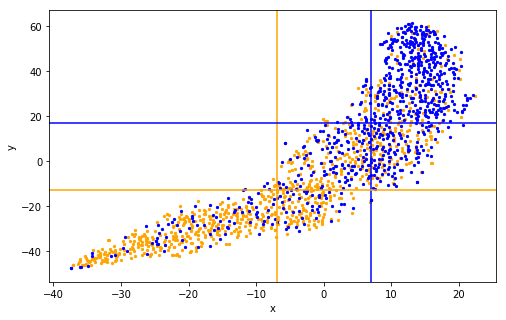

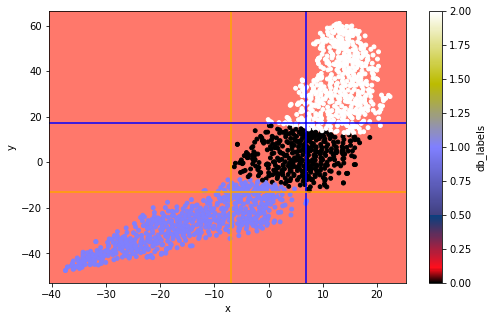

In [291]:
#adjj_df = pd.DataFrame(adjj_vectors)
adjj_df = set_to_data_index(pd.DataFrame(adjj_vectors))
adjj_df = reduce_data(adjj_df, 200)
adjj_df = meanshift_for_df(adjj_df)

show_reduced(adjj_df)
show_clustered(adjj_df)

baddata score: 0
tsne complete
18.648341423312942
number of estimated clusters : 4


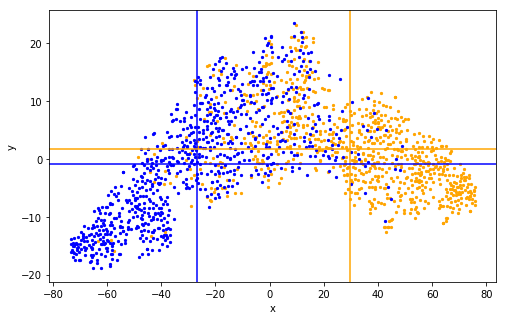

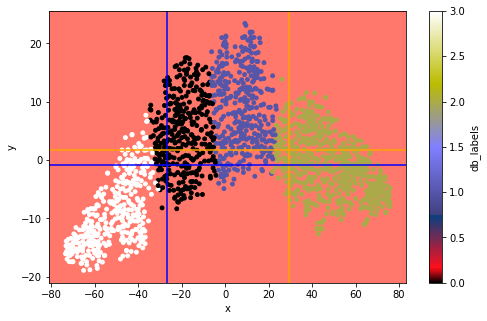

In [292]:
noun_df = set_to_data_index(pd.DataFrame(noun_vectors))
noun_df = reduce_data(noun_df, 200)
noun_df = meanshift_for_df(noun_df)

show_reduced(noun_df)
show_clustered(noun_df)

baddata score: 0
tsne complete
19.919588845572296
number of estimated clusters : 3


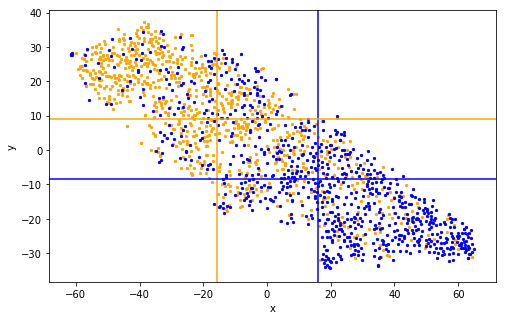

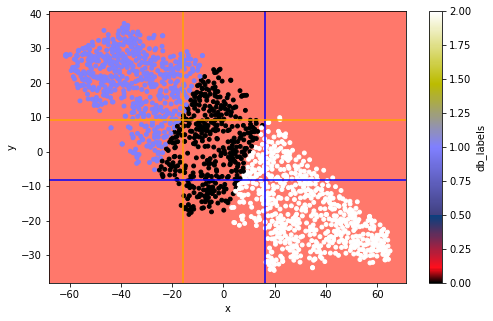

In [293]:
verb_df = set_to_data_index(pd.DataFrame(verb_vectors))
verb_df = reduce_data(verb_df, 200)
verb_df = meanshift_for_df(verb_df)

show_reduced(verb_df)
show_clustered(verb_df)

baddata score: 0
tsne complete
19.593607758116267
number of estimated clusters : 3


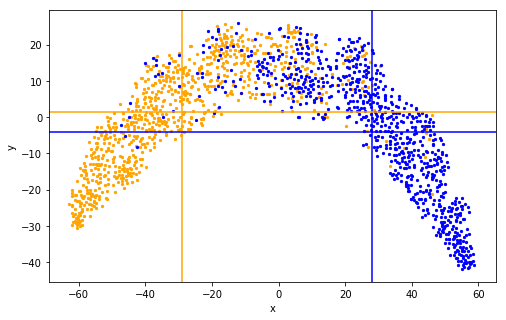

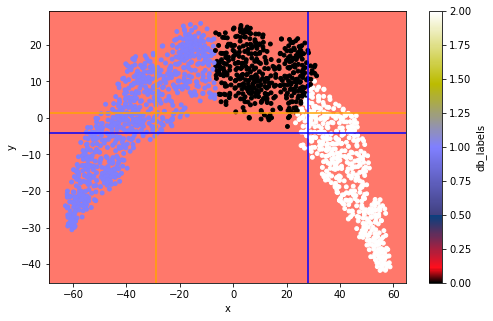

In [294]:
sentence_df = set_to_data_index(pd.DataFrame(vectors))
sentence_df = reduce_data(sentence_df, 200)
sentence_df = meanshift_for_df(sentence_df)

show_reduced(sentence_df)
show_clustered(sentence_df)

In [341]:
## convert the dbscan labels to probability of truthfulness
def convert_dbscan_to_probs(df):
    for dlab in df.db_labels.unique():
        label_d        = df[df.db_labels == dlab]
        label_d_is_tru = sum(label_d.truthfulness == 1); #print label_d_is_tru
        label_d_len    = len(label_d);                   #print label_d_len
        label_d_index  = label_d.index
        rval = 0
        if(label_1 > 0):
            rval = label_d_is_tru/float(label_d_len)
            
        #print dlab, rval, '\n'
        df = df.set_value(label_d_index, 'tru_probs_dbscan', rval)
    return df
    
sentence_df = convert_dbscan_to_probs(sentence_df)
verb_df     = convert_dbscan_to_probs(verb_df)
noun_df     = convert_dbscan_to_probs(noun_df)
adjj_df     = convert_dbscan_to_probs(adjj_df)

In [368]:
def convert_xy_to_probs(df, dfname):
    print 'converting xy values for', dfname, '\n'
    xlist = ['x', 'y']
    xy_probs   = forest_learn_from(df, xlist, 'truthfulness')
    xy_prob_df = pd.DataFrame(xy_probs)
    xy_prob_df.rename(columns={0:'truthful_xy'}, inplace=True)
    xy_prob_df = set_to_data_index(xy_prob_df)
    #display(xy_prob_df)
    df = df.set_value(df.index, 'xy_probs', xy_prob_df['truthful_xy'])
    print '-----------------------------------------------------\n'
    return df

sentence_df = convert_xy_to_probs(sentence_df, 'sentence')
verb_df     = convert_xy_to_probs(verb_df, 'verb')
noun_df     = convert_xy_to_probs(noun_df, 'noun')

converting xy values for sentence 

Using these features: ['x', 'y']
(320, 2)
            accuracy: 0.8609375
accuracy on all data: 0.88875
-----------------------------------------------------

converting xy values for verb 

Using these features: ['x', 'y']
(320, 2)
            accuracy: 0.6828125
accuracy on all data: 0.74625
-----------------------------------------------------

converting xy values for noun 

Using these features: ['x', 'y']
(320, 2)
            accuracy: 0.8015625
accuracy on all data: 0.84125
-----------------------------------------------------



In [369]:
y_prob_pd['tsne_x']    = sentence_df['x']
y_prob_pd['tsne_y']    = sentence_df['y']
y_prob_pd['ms_labels'] = sentence_df['db_labels']
y_prob_pd['tru_probs_dbscan_sentence'] = sentence_df['tru_probs_dbscan']
y_prob_pd['xy_probs_sentence']         = sentence_df['xy_probs']

y_prob_pd['verb_x']      = verb_df['x']
y_prob_pd['verb_y']      = verb_df['y']
y_prob_pd['verb_labels'] = verb_df['db_labels']
y_prob_pd['tru_probs_dbscan_verb'] = verb_df['tru_probs_dbscan']
y_prob_pd['xy_probs_verb']         = sentence_df['xy_probs']

y_prob_pd['noun_x']      = noun_df['x']
y_prob_pd['noun_y']      = noun_df['y']
y_prob_pd['noun_labels'] = noun_df['db_labels']
y_prob_pd['tru_probs_dbscan_noun'] = noun_df['tru_probs_dbscan']
y_prob_pd['xy_probs_noun']         = sentence_df['xy_probs']


xlist = ['negative', 'positive', 'wc', 'tf_deceptive', 'tf_truthful',\
         'tru_probs_dbscan_sentence', 'tru_probs_dbscan_verb', 'tru_probs_dbscan_noun',\
         'xy_probs_sentence', 'xy_probs_verb', 'xy_probs_noun'
        ]
y_column = 'truthfulness'
all_predictions = forest_learn_from(y_prob_pd, xlist, y_column)

Using these features: ['negative', 'positive', 'wc', 'tf_deceptive', 'tf_truthful', 'tru_probs_dbscan_sentence', 'tru_probs_dbscan_verb', 'tru_probs_dbscan_noun', 'xy_probs_sentence', 'xy_probs_verb', 'xy_probs_noun']
(320, 11)
            accuracy: 0.953125
accuracy on all data: 0.9625


In [296]:
## Finally, let's see if the ratios of various parts of speech among the reviews
## can help us distinguish true from fake 

type_ratios_df = set_to_data_index(pd.DataFrame(type_ratios))
type_ratios_df.rename(columns={0:'sen', 1:'adjj', 2:'verb', 3:'noun'}, inplace=True)
type_ratios_df['adjj_vs'] = type_ratios_df['adjj']/type_ratios_df['sen']
type_ratios_df['verb_vs'] = type_ratios_df['verb']/type_ratios_df['sen']
type_ratios_df['noun_vs'] = type_ratios_df['noun']/type_ratios_df['sen']
type_ratios_df.head()

,sen,adjj,verb,noun,adjj_vs,verb_vs,noun_vs
orig_index,,,,,,,
177,43,4,10,17,0.093023,0.232558,0.395349
484,42,5,15,18,0.119048,0.357143,0.428571
193,39,9,7,18,0.230769,0.179487,0.461538
851,39,2,11,23,0.051282,0.282051,0.589744
1380,76,17,10,31,0.223684,0.131579,0.407895


In [372]:
y_prob_pd['adjj_vs'] = type_ratios_df['adjj_vs']
y_prob_pd['verb_vs'] = type_ratios_df['verb_vs']
y_prob_pd['noun_vs'] = type_ratios_df['noun_vs']

xlist = ['negative', 'positive', 'wc', 'tf_deceptive', 'tf_truthful',\
         'tru_probs_dbscan_sentence', 'tru_probs_dbscan_verb', 'tru_probs_dbscan_noun',\
         'xy_probs_sentence', 'xy_probs_verb', 'xy_probs_noun',\
         'adjj_vs', 'verb_vs', 'noun_vs'\
        ]

y_column = 'truthfulness'
all_predictions = forest_learn_from(y_prob_pd, xlist, y_column)

Using these features: ['negative', 'positive', 'wc', 'tf_deceptive', 'tf_truthful', 'tru_probs_dbscan_sentence', 'tru_probs_dbscan_verb', 'tru_probs_dbscan_noun', 'xy_probs_sentence', 'xy_probs_verb', 'xy_probs_noun', 'adjj_vs', 'verb_vs', 'noun_vs']
(320, 14)
            accuracy: 0.95546875
accuracy on all data: 0.964375
